# Parameters

In [463]:
# Choose model checkpoint
# NOTE: make sure CHOSEN_MODEL_CKPT exists in `model_configs` below

# CHOSEN_MODEL_CKPT = 'siamese_contrastive.pt'
# CHOSEN_MODEL_CKPT = 'siamese_contrastive_7k.pt'
# CHOSEN_MODEL_CKPT = 'siamese_contrastive_test-f1=0.301_splitting-by-query_cc12m_rubert_tiny_ep_1.pt'
CHOSEN_MODEL_CKPT = 'siamese_contrastive_soft-neg_epoch=1_val-f1=0.829_val-pos-acc=0.802_val-neg-acc=0.932_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-f1-threshold=1.010.pt'

In [464]:
DATA_PATH = 'data/'

NAMES_AS_DESCRIPTIONS = False
RENDERED_VAL_FILEPATH = 'tables_OZ_geo_5500/processed/pairwise-rendered/val/num-rows=3977_limit-pos=None_pos-neg=1.0_hard-soft=0.5_seed=42/pairs.parquet'
RENDERED_TEST_FILEPATH = 'tables_OZ_geo_5500/processed/pairwise-rendered/test/num-rows=4476_limit-pos=None_pos-neg=1.0_hard-soft=0.5_seed=42/pairs.parquet'
EMBEDDINGS_FILE_NAME = 'embeddings/OZ_geo_5500/siamese-embeddings_num-rows=5562.parquet'
IMG_DATASET_NAME = 'images_OZ_geo_5500'

In [465]:
import torch

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 768 if torch.cuda.is_available() else 8
LIMIT_PAIRS = None if torch.cuda.is_available() else 6

# Log into services

In [466]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

In [467]:
# Use tokens from .env

import os
from dotenv import load_dotenv

import huggingface_hub
import wandb

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
huggingface_hub.login(token=HF_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Imports

In [468]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchinfo import summary
import transformers
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
        get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

import cv2

from PIL import Image
from tqdm.auto import tqdm

import json
from itertools import product

# import datasets
# from datasets import Dataset, concatenate_datasets
import argparse
import requests

from io import BytesIO
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import more_itertools

# Evaluation loop

## Run evaluation

In [469]:
# Download models' weights & text/image datasets

from huggingface_hub import snapshot_download
from pathlib import Path

REPO_ID = "INDEEPA/clip-siamese"
LOCAL_DIR = Path("data/train_results")
LOCAL_DIR.mkdir(parents=True, exist_ok=True)

snapshot_download(
    repo_id=REPO_ID,
    repo_type='dataset',
    local_dir='data',
    allow_patterns=[
        f"train_results/{CHOSEN_MODEL_CKPT}",
        RENDERED_VAL_FILEPATH,
        RENDERED_TEST_FILEPATH,
        EMBEDDINGS_FILE_NAME,
        f"{IMG_DATASET_NAME}.zip",
    ],
)

!unzip -n -q data/{IMG_DATASET_NAME}.zip -d data/

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [470]:
emb_table = pd.read_parquet(DATA_PATH + EMBEDDINGS_FILE_NAME)   
emb_table.head()

,sku,siamese_emb
0,1871769771,"[-0.36614302, 0.025540195, 0.0073242486, -0.06..."
1,1679550303,"[-0.28556544, 0.037392754, -0.13363522, -0.022..."
2,1200553001,"[-0.16812347, 0.014725633, -0.06232158, -0.042..."
3,922231521,"[-0.1102242, 0.008129355, -0.025397494, 0.0159..."
4,922230517,"[-0.19517854, 0.030946404, -0.116421536, -0.02..."


# Compute distances

In [472]:
val_pairwise_df = pd.read_parquet(DATA_PATH + RENDERED_VAL_FILEPATH)
test_pairwise_df = pd.read_parquet(DATA_PATH + RENDERED_TEST_FILEPATH)

skus_with_embs = set(emb_table['sku'])
val_pairwise_df = val_pairwise_df[val_pairwise_df['sku_first'].isin(skus_with_embs) & val_pairwise_df['sku_second'].isin(skus_with_embs)]
test_pairwise_df = test_pairwise_df[test_pairwise_df['sku_first'].isin(skus_with_embs) & test_pairwise_df['sku_second'].isin(skus_with_embs)]

assert len(val_pairwise_df) > 0, "No pairs with both embeddings computed found in the validation set"
assert len(test_pairwise_df) > 0, "No pairs with both embeddings computed found in the test set"

# Set 'sku' as index for easy lookup
emb_table_indexed = emb_table.set_index('sku')

def compute_euclidean_distance(row):
    """Compute Euclidean distance between original embeddings using indexed DataFrame"""
    try:
        emb1 = np.array(emb_table_indexed.loc[row['sku_first'], 'siamese_emb'])
        emb2 = np.array(emb_table_indexed.loc[row['sku_second'], 'siamese_emb'])
        return np.linalg.norm(emb1 - emb2)
    except KeyError:
        return np.nan

# Add L2 distances to DataFrames
val_pairwise_df['siam_l2_dist'] = val_pairwise_df.apply(compute_euclidean_distance, axis=1)
test_pairwise_df['siam_l2_dist'] = test_pairwise_df.apply(compute_euclidean_distance, axis=1).dropna()

print("Distance statistics:")
from IPython.display import display
display(val_pairwise_df['siam_l2_dist'].describe().to_frame())

Distance statistics:


,siam_l2_dist
count,3977.000000
mean,2.480026
std,2.843629
min,0.000000
25%,0.065539
50%,1.251935
75%,4.024059
max,14.806264


In [473]:
import numpy as np
import pandas as pd

# GRID_STEP = 0.0025
GRID_STEP = 0.005

# Compute TPR at a grid of FPR values over validation distances
from sklearn.metrics import roc_curve

# Get ground truth and scores
y_true = val_pairwise_df['label'].values
y_score = -val_pairwise_df['siam_l2_dist'].values  # negative distance: lower means more similar

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

# Define FPR grid
fpr_grid = np.arange(GRID_STEP, 1 + GRID_STEP, GRID_STEP)

# Interpolate TPR and threshold at each FPR grid point
tpr_interp = np.interp(fpr_grid, fpr, tpr)
thr_interp = np.interp(fpr_grid, fpr, thresholds)

# Create DataFrame for display
tpr_fpr_thr_df = pd.DataFrame({
    'fpr': fpr_grid,
    'tpr': tpr_interp,
    'thr': -thr_interp  # Convert back to distance
})

print("Head of TPR@FPR grid:")
display(tpr_fpr_thr_df.head(10))

# print("Tail of TPR@FPR grid:")
# display(tpr_fpr_thr_df.tail())

Head of TPR@FPR grid:


,fpr,tpr,thr
0,0.005,0.123177,0.007999
1,0.010,0.358472,0.039319
2,0.015,0.508939,0.080406
3,0.020,0.543489,0.129473
4,0.025,0.565611,0.167860
5,0.030,0.621921,0.267380
6,0.035,0.658120,0.388367
7,0.040,0.692308,0.518592
8,0.045,0.713424,0.647355
9,0.050,0.747612,0.802941


In [498]:
# Choose FPR or Threshold

# CHOSEN_FPR = 0.05
# CHOSEN_THR = None

CHOSEN_FPR = None
CHOSEN_THR = 1.01

if CHOSEN_THR is None:
    assert CHOSEN_FPR is not None, "Either FPR or Threshold must be provided"
elif CHOSEN_FPR is not None:
    assert CHOSEN_THR is None, "Either FPR or Threshold must be provided, not both"

# Compute ROC curve on validation set
from sklearn.metrics import roc_curve

y_true = val_pairwise_df['label'].values
y_score = -val_pairwise_df['siam_l2_dist'].values  # negative distance: lower means more similar

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

if CHOSEN_FPR is not None:
    # Find threshold corresponding to CHOSEN_FPR (find first fpr >= CHOSEN_FPR)
    idx = np.searchsorted(fpr, CHOSEN_FPR, side='left')
    if idx >= len(fpr):
        idx = len(fpr) - 1

    THR_AT_CHOSEN_FPR = -thresholds[idx]  # convert back to distance
    TPR_AT_CHOSEN_FPR = tpr[idx]
    FPR_AT_CHOSEN_THR = fpr[idx]
    
    # Set final values
    FINAL_FPR = CHOSEN_FPR
    FINAL_TPR = TPR_AT_CHOSEN_FPR
    FINAL_THR = THR_AT_CHOSEN_FPR

    print(f"CHOSEN_FPR: {CHOSEN_FPR:.3f}")
    print('-' * 40)
    print(f"TPR (Recall) @ CHOSEN_FPR: {TPR_AT_CHOSEN_FPR:.3f}")
    print(f"Threshold @ CHOSEN_FPR: {THR_AT_CHOSEN_FPR:.3f}")
else:
    # Find FPR corresponding to CHOSEN_THR
    threshold_score = -CHOSEN_THR  # convert threshold to y_score space
    idx = np.searchsorted(thresholds, threshold_score, side='left')
    if idx >= len(thresholds):
        idx = len(thresholds) - 1
    
    FPR_AT_CHOSEN_THR = fpr[idx]
    TPR_AT_CHOSEN_FPR = tpr[idx]
    THR_AT_CHOSEN_FPR = CHOSEN_THR
    
    # Set final values
    FINAL_FPR = FPR_AT_CHOSEN_THR
    FINAL_TPR = TPR_AT_CHOSEN_FPR
    FINAL_THR = CHOSEN_THR

    print(f"CHOSEN_THR: {CHOSEN_THR:.3f}")
    print('-' * 40)
    print(f"FPR @ CHOSEN_THR: {FPR_AT_CHOSEN_THR:.3f}")
    print(f"TPR (Recall) @ CHOSEN_THR: {TPR_AT_CHOSEN_FPR:.3f}")

# For the prediction step, use the final threshold
CHOSEN_THR = FINAL_THR

CHOSEN_THR: 1.010
----------------------------------------
FPR @ CHOSEN_THR: 1.000
TPR (Recall) @ CHOSEN_THR: 1.000


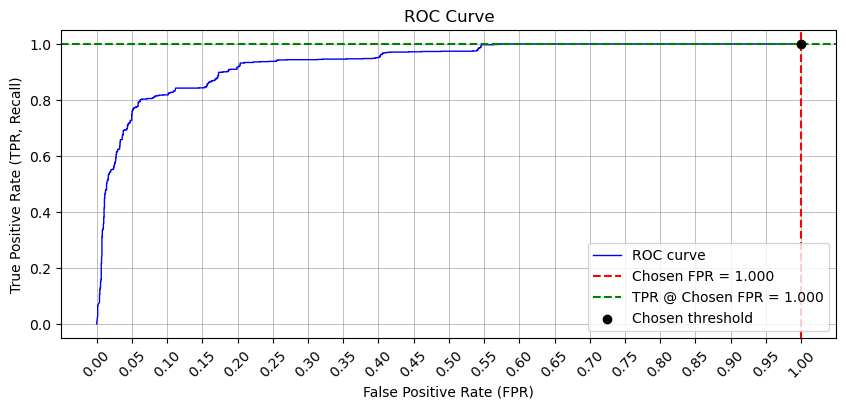

In [501]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, label='ROC curve', color='blue', linewidth=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR, Recall)')
plt.title('ROC Curve')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray', alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.3)

# Set x-axis ticks with step 0.05
x_ticks = np.arange(0, 1.01, 0.05)
plt.xticks(x_ticks, rotation=45)

# Plot vertical line at CHOSEN_FPR
plt.axvline(x=FINAL_FPR, color='red', linestyle='--', label=f'Chosen FPR = {FINAL_FPR:.3f}')

# Plot horizontal line at corresponding TPR
chosen_tpr = tpr[idx]
plt.axhline(y=chosen_tpr, color='green', linestyle='--', label=f'TPR @ Chosen FPR = {chosen_tpr:.3f}')

# Mark the chosen point
plt.scatter([FINAL_FPR], [FINAL_TPR], color='black', zorder=5, label='Chosen threshold')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [504]:
# Make predictions at chosen threshold on test_pairwise_df

# Assume test_pairwise_df has a column 'siam_l2_dist'
# Predict 1 if distance <= FINAL_THR, else 0

test_pairwise_df['prediction'] = (test_pairwise_df['siam_l2_dist'] <= FINAL_THR).astype(int)

# Optionally, print value counts for sanity check
print(f"Prediction value counts at FPR={FINAL_FPR}:")
print(test_pairwise_df['prediction'].value_counts().to_frame())

Prediction value counts at FPR=1.0:
            count
prediction       
0            2709
1            1767


Test set metrics at FPR=1.0:
Accuracy:  0.8255
Precision: 0.9123
Recall:    0.7203
F1 Score:  0.8050


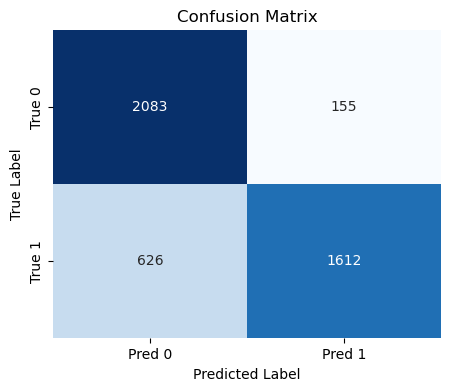


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      2238
           1       0.91      0.72      0.80      2238

    accuracy                           0.83      4476
   macro avg       0.84      0.83      0.82      4476
weighted avg       0.84      0.83      0.82      4476



In [506]:
# Compute metrics on test set
# Assume test_pairwise_df has columns: 'label' (ground truth), 'prediction' (predicted)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_pairwise_df['label']
y_pred = test_pairwise_df['prediction']

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"Test set metrics at FPR={FINAL_FPR}:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Better confusion matrix visualization using seaborn
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

In [508]:
# save predictions w/ metrics as metadata

import pyarrow as pa
import pyarrow.parquet as pq

save_folder_path = Path(RENDERED_TEST_FILEPATH).parent
save_file_path = save_folder_path / f'preds_fpr={FINAL_FPR}.parquet'
print(f"Saving predictions to:\n{save_file_path}")
save_file_path = Path(DATA_PATH) / save_file_path
save_file_path.parent.mkdir(parents=True, exist_ok=True)

meta = {
    "chosen_fpr": round(float(FINAL_FPR), 3),
    "tpr": round(float(FINAL_TPR), 3),
    "threshold": round(float(FINAL_THR), 3),
    "accuracy": round(float(acc), 3),
    "precision": round(float(prec), 3),
    "recall": round(float(rec), 3),
}

# Convert DataFrame to PyArrow Table
table = pa.Table.from_pandas(test_pairwise_df)

# Convert metadata values to strings (required for PyArrow metadata)
metadata_strings = {key: str(value) for key, value in meta.items()}

# Add custom metadata to the schema
table = table.replace_schema_metadata(metadata_strings)

# Write with PyArrow
pq.write_table(table, save_file_path)

print(f"\nSaved predictions with metadata:\n{meta}")

Saving predictions to:
tables_OZ_geo_5500/processed/pairwise-rendered/test/num-rows=4476_limit-pos=None_pos-neg=1.0_hard-soft=0.5_seed=42/preds_fpr=1.0.parquet

Saved predictions with metadata:
{'chosen_fpr': 1.0, 'tpr': 1.0, 'threshold': 1.01, 'accuracy': 0.826, 'precision': 0.912, 'recall': 0.72}
